# A/B-тестирование

## Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Изучение данных

In [1]:
import pandas as pd
import scipy.stats as stats
import datetime as dt
import numpy as np
import math as mth
from scipy import stats as st
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from plotly import graph_objects as go

<div style="border:solid blue 1px; padding: 20px"> 
Сохраним в переменной marketing_events календарь маркетинговых событий на 2020 год, в переменной new_users - пользователей, зарегистрировавшиеся с 7 по 21 декабря 2020 года, в переменной events - действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года и в переменной participants - таблицу участников тестов

In [2]:
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv')
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv')

In [3]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [4]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [5]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [6]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [7]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [8]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [9]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [10]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [11]:
events.groupby('event_name').agg('count')

,user_id,event_dt,details
event_name,,,
login,189552,189552,0
product_cart,62462,62462,0
product_page,125563,125563,0
purchase,62740,62740,62740


<div style="border:solid blue 1px; padding: 20px"> 
Пропусков в данных нет, кроме колонки details в таблице events. Это обусловлено тем, что в ней проставляется сумма покупки, то есть когда наблюдаемое событие - purchase

<div style="border:solid blue 1px; padding: 20px"> 
Заполним эти пропуски нулями

In [12]:
events = events.fillna(0)

In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     440317 non-null  float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


<div style="border:solid blue 1px; padding: 20px"> 
Далее проверим данные на дубликаты

In [14]:
participants['group'].unique()

array(['A', 'B'], dtype=object)

In [15]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [16]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [17]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [18]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [19]:
marketing_events['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [20]:
marketing_events['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

<div style="border:solid blue 1px; padding: 20px"> 
Неявных дубликатов не обнаружено

In [21]:
participants.duplicated().sum()

0

In [22]:
new_users.duplicated().sum()

0

In [23]:
events.duplicated().sum()

0

In [24]:
marketing_events.duplicated().sum()

0

<div style="border:solid blue 1px; padding: 20px"> 
Явных дубликатов также не обнаружено

In [25]:
new_users['user_id'].duplicated().sum()

0

<div style="border:solid blue 1px; padding: 20px"> 
По всем пользователям отображена одна дата регистрации

<div style="border:solid blue 1px; padding: 20px"> 
Преобразуем тип данных даты в таблицах new_users, events, marketing_events

In [26]:
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format="%Y-%m-%d")

In [27]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [28]:
events['event_dt'] = pd.to_datetime(events['event_dt'], format="%Y-%m-%d %H:%M:%S")

In [29]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     440317 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [30]:
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'], format="%Y-%m-%d")
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'], format="%Y-%m-%d")

In [31]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


### Вывод

<div style="border:solid blue 1px; padding: 20px"> 
Для оценки результатов AB теста представлены 4 таблицы с данными: календарь маркетинговых событий на 2020 год; список пользователей, зарегистрировавшиеся с 7 по 21 декабря 2020 года; действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года и таблица участников тестов. Пропуски в данных не обнаружены, кроме столбца details таблицы с действиями пользователей. Это обусловлено тем, что данный столбец заполняется только в случае совершении покупки (в нем проставляется цена). Дубликаты, как явные, так и неявные также не были обнаружены.

## Оценка корректности проведения теста

<div style="border:solid blue 1px; padding: 20px"> 
Проверим проведенный тест на соотвествие техническому заданию

### Соответствие ТЗ

<div style="border:solid blue 1px; padding: 20px"> 
<b>1) Название теста: recommender_system_test</b>

<div style="border:solid blue 1px; padding: 20px"> 
Как мы видели на предыдущем этапе, при проверке на наличии дубликатов, в таблице участников теста указаны 2 AB теста - 'recommender_system_test', 'interface_eu_test'

In [32]:
participants.groupby('ab_test').agg({'user_id':'count'})

,user_id
ab_test,
interface_eu_test,11567
recommender_system_test,6701


<div style="border:solid blue 1px; padding: 20px"> 
Их них 11567 человек участовали в тесте interface_eu_test, а 6701 - в нашем тесте, recommender_system_test

<div style="border:solid blue 1px; padding: 20px"> 
Для дальнейшей проверки отберем только user_id пользователей, участвовавших в нашем тесте и объединим данные из таблиц с действиями и информацией о новых пользователях

In [33]:
true_participants = participants.query('ab_test == "recommender_system_test"')

In [34]:
true_participants['ab_test'].unique()

array(['recommender_system_test'], dtype=object)

In [35]:
all_data = true_participants.merge(events, on='user_id', how='left')

In [36]:
all_data = all_data.merge(new_users, on='user_id', how='left')

In [37]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27724 entries, 0 to 27723
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     27724 non-null  object        
 1   group       27724 non-null  object        
 2   ab_test     27724 non-null  object        
 3   event_dt    24698 non-null  datetime64[ns]
 4   event_name  24698 non-null  object        
 5   details     24698 non-null  float64       
 6   first_date  27724 non-null  datetime64[ns]
 7   region      27724 non-null  object        
 8   device      27724 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 2.1+ MB


<div style="border:solid blue 1px; padding: 20px"> 
Похоже, что не все пользователи совершали действия после регистрации

<div style="border:solid blue 1px; padding: 20px"> 
<b>2) Дата запуска: 2020-12-07;</b>

In [38]:
all_data['event_dt'].min()

Timestamp('2020-12-07 00:05:57')

In [39]:
all_data['first_date'].min()

Timestamp('2020-12-07 00:00:00')

<div style="border:solid blue 1px; padding: 20px"> 
Дата запуска действительно 7 декабря 2020 года

<div style="border:solid blue 1px; padding: 20px"> 
<b>3) Дата остановки набора новых пользователей: 2020-12-21;</b>

In [40]:
all_data['first_date'].max()

Timestamp('2020-12-21 00:00:00')

<div style="border:solid blue 1px; padding: 20px"> 
Последний пользователь действительно зарегистрировался 21 декабря

<div style="border:solid blue 1px; padding: 20px"> 
<b>4) Дата остановки: 2021-01-04;</b>

In [41]:
all_data['event_dt'].max()

Timestamp('2020-12-30 12:42:57')

<div style="border:solid blue 1px; padding: 20px"> 
Последнее событие произошло 30 декабря 2020 года

<div style="border:solid blue 1px; padding: 20px"> 
<b>5) Аудитория: 15% новых пользователей из региона EU;</b>

In [42]:
all_data.groupby('region').agg({'user_id':'nunique'})

,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


<div style="border:solid blue 1px; padding: 20px"> 
Большая часть участников теста из Европы- 6351 человек из 6701 (~ 95%), но также есть 223 пользователя из Северной Америки, 72 из Азиатско-Тихоокеанского региона и 55 из СНГ

In [43]:
new_users.pivot_table(index='region', values='user_id', aggfunc='nunique')

,user_id
region,
APAC,3153
CIS,3155
EU,46270
N.America,9155


<div style="border:solid blue 1px; padding: 20px"> 
Всего 46270 пользователей зарегистрировались из Европы, 9155 из Северной Америки, 3155 из СНГ и 3153 из Азиатско-Тихоокеанского региона

In [44]:
new_users[new_users['region']=='EU'].agg({'user_id':'nunique'})*0.15

user_id    6940.5
dtype: float64

In [45]:
all_data[all_data['region']=='EU'].agg({'user_id':'nunique'}) / new_users[new_users['region']=='EU'].agg({'user_id':'nunique'}) * 100

user_id    13.725956
dtype: float64

<div style="border:solid blue 1px; padding: 20px"> 
Заявленные 15% от новых европейских пользователей - 6941 человек, в нашем тесте всего участвует 6701, а из Европы всего 6351. Для дальнейшего исследования оставим только 6351 европейских пользователей (но количество будет меньше указнного в ТЗ).

In [46]:
all_data_EU = all_data[all_data['region']=='EU']

In [47]:
all_data_EU.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26290 entries, 0 to 26289
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     26290 non-null  object        
 1   group       26290 non-null  object        
 2   ab_test     26290 non-null  object        
 3   event_dt    23420 non-null  datetime64[ns]
 4   event_name  23420 non-null  object        
 5   details     23420 non-null  float64       
 6   first_date  26290 non-null  datetime64[ns]
 7   region      26290 non-null  object        
 8   device      26290 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(6)
memory usage: 2.0+ MB


In [48]:
all_data_EU['user_id'].nunique()

6351

In [49]:
all_data_EU_check = all_data_EU.fillna("no")

In [50]:
all_data_EU_check[all_data_EU_check['event_name']=='no'].agg({'user_id':'nunique'})

user_id    2870
dtype: int64

<div style="border:solid blue 1px; padding: 20px"> 
По 2870 пользователям у нас нет данных о событиях после регистрации

<b>6) Ожидаемое количество участников теста: 6000;</b>

<div style="border:solid blue 1px; padding: 20px"> 
В тесте участвовало на 701 человека больше (~ +11,7%), или на 351 больше, если считать от европейских пользователей (~ +5,85%)

<b>7) Ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%</b>

<div style="border:solid blue 1px; padding: 20px"> 
По ТЗ тест должен был остановиться 4 января, спустя 2 недели после окончания регистрации новых пользователей - 21 декабря. Но фактически мы видим, что тест остановился 30 декабря. Далее в период с 31 по 4 января никаких действий не совершалось. Возможно, это связяно с праздничными днями.

In [51]:
all_data_EU.head()

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC
1,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:56,purchase,4.99,2020-12-07,EU,PC
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,EU,PC
3,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-25 00:04:57,product_cart,0.00,2020-12-07,EU,PC
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,EU,PC


<div style="border:solid blue 1px; padding: 20px"> 
Проверим долю пользователей, не проживших положенные согласно ТЗ 14 дней

In [52]:
all_data_EU[all_data_EU['first_date']>"2020-12-14"].agg({'user_id':'nunique'})/all_data_EU.agg({'user_id':'nunique'})

user_id    0.453787
dtype: float64

<div style="border:solid blue 1px; padding: 20px"> 
Таким образом решив удалить пользователей, не проживших положенные согласно ТЗ 14 дней, мы потеряем 45% клиентов

<div style="border:solid blue 1px; padding: 20px"> 
Также проверим, сколько в среднем дней проходит с даты регистрации пользователя до совершения первого события 

In [53]:
first_event = all_data_EU.groupby(['user_id', 'first_date']).agg({'event_dt':'first'}).reset_index()

In [54]:
first_event['diff'] = first_event['event_dt'] - first_event['first_date']

In [55]:
first_event['diff'].mean()

Timedelta('0 days 12:21:30.352197644')

In [56]:
first_event['diff'].min()

Timedelta('0 days 00:00:05')

In [57]:
first_event['diff'].max()

Timedelta('8 days 14:08:48')

<div style="border:solid blue 1px; padding: 20px"> 
Как мы видим, 14 дней не обязательны для совершения пользователем первого события. В среднем для этого необходимо 12,5 часов, минимум 5 секунд, максимум 8,5 дней.
    
Таким образом оставим данные таких пользователей.

<div style="border:solid blue 1px; padding: 20px"> 
Проверим также, есть ли события, совершенные пользователями спустя 14 дней после регистрации

In [58]:
last_event = all_data_EU.groupby(['user_id', 'first_date']).agg({'event_dt':'last'}).reset_index()

In [59]:
all_data_EU['diff'] = all_data_EU['event_dt'] - all_data_EU['first_date']

/tmp/ipykernel_32/2792481841.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_data_EU['diff'] = all_data_EU['event_dt'] - all_data_EU['first_date']


In [60]:
all_data_EU['diff'].max()

Timedelta('23 days 12:42:57')

<div style="border:solid blue 1px; padding: 20px"> 
Такие события есть. Согласно ТЗ нам необходимо оставить события в рамках 14 дней после регистрации.

In [61]:
all_data_EU_check = all_data_EU.query('diff < "14 days"')

In [62]:
all_data_EU_check['diff'].max()

Timedelta('13 days 23:52:52')

In [63]:
all_data_EU_check['user_id'].nunique()

3481

In [64]:
all_data_EU.agg({'user_id':'nunique'}) - all_data_EU_check.agg({'user_id':'nunique'})

user_id    2870
dtype: int64

In [65]:
all_data_EU[all_data_EU['group']=='A'].agg({'user_id':'nunique'}) - all_data_EU_check[all_data_EU_check['group']=='A'].agg({'user_id':'nunique'})

user_id    1030
dtype: int64

In [66]:
all_data_EU[all_data_EU['group']=='B'].agg({'user_id':'nunique'}) - all_data_EU_check[all_data_EU_check['group']=='B'].agg({'user_id':'nunique'})

user_id    1840
dtype: int64

In [67]:
(all_data_EU.agg({'user_id':'nunique'}) - all_data_EU_check.agg({'user_id':'nunique'})) / all_data_EU.agg({'user_id':'nunique'})

user_id    0.451897
dtype: float64

<div style="border:solid blue 1px; padding: 20px"> 
Удалив такие события, мы потерям 2870 клиентов (45%), причем большую часть из клиентов группы B. 
Как мы проверяли ранее, это пользователи, по которым нет ни одного события. Скорее всего произошел какой-то сбой, поэтому мы не дополучили данные по этим клиентам.

In [68]:
all_data_EU = all_data_EU.query('diff < "14 days"')

<div style="border:solid blue 1px; padding: 20px"> 
Ожидаемый эффект измерим немного позднее. Далее перейдем к проверке аудитории теста.

### Проверка аудитории теста

<div style="border:solid blue 1px; padding: 20px"> 
Проверим, есть ли среди отобранных 3481 человек одни и те же пользователи в двух группах

In [69]:
check = all_data_EU.groupby('user_id').agg({'group':'nunique'})
check[check['group'] == 2].count()

group    0
dtype: int64

<div style="border:solid blue 1px; padding: 20px"> 
Таких пользователей нет

<div style="border:solid blue 1px; padding: 20px"> 
Проверим, есть ли пользователи, принимавшие участие в обоих тестах

In [70]:
check_2 = participants.groupby('user_id').agg({'ab_test':'nunique'})
check_2[check_2['ab_test'] == 2].count()

ab_test    1602
dtype: int64

<div style="border:solid blue 1px; padding: 20px"> 
Изначально всего было таких 1602 пользователя

<div style="border:solid blue 1px; padding: 20px"> 
Проверим, как пользователи из группы B теста interface_eu_test распределены среди пользователей теста recommender_system_test

In [71]:
participants_interface = participants[participants['ab_test']=='interface_eu_test']
participants_interface_B = participants_interface[participants_interface['group']=='B']
participants_interface_B = participants_interface_B.merge(all_data_EU, on='user_id', how='left')
participants_interface_B.head()

,user_id,group_x,ab_test_x,group_y,ab_test_y,event_dt,event_name,details,first_date,region,device,diff
0,2BA8FA8754D1FE50,B,interface_eu_test,NaN,NaN,NaT,NaN,NaN,NaT,NaN,NaN,NaT
1,FB6F6BC119E1DBD5,B,interface_eu_test,A,recommender_system_test,2020-12-18 05:10:22,product_page,0.0,2020-12-18,EU,Android,0 days 05:10:22
2,FB6F6BC119E1DBD5,B,interface_eu_test,A,recommender_system_test,2020-12-24 00:41:26,product_page,0.0,2020-12-18,EU,Android,6 days 00:41:26
3,FB6F6BC119E1DBD5,B,interface_eu_test,A,recommender_system_test,2020-12-18 05:10:21,login,0.0,2020-12-18,EU,Android,0 days 05:10:21
4,FB6F6BC119E1DBD5,B,interface_eu_test,A,recommender_system_test,2020-12-24 00:41:25,login,0.0,2020-12-18,EU,Android,6 days 00:41:25


In [72]:
participants_interface_B_query = participants_interface_B.query('ab_test_y == "recommender_system_test"')
participants_interface_B_query.groupby('group_y').agg({'user_id':'nunique'})

,user_id
group_y,
A,325
B,106


In [73]:
participants_interface_B_query['user_id'].nunique()

431

<div style="border:solid blue 1px; padding: 20px"> 
Всего 431 пользователей из B группы первого теста участвовал в нашем тесте: из них 325 в группе А, а 106 в группе В. Проверим, равенство долей пропорций таких участников в двух группах нашего целевого теста.

In [74]:
all_data_EU.groupby('group').agg({'user_id':'nunique'})

,user_id
group,
A,2604
B,877


In [75]:
interface_B_clients = np.array([325, 106])
total_recommender_clients = np.array([2604, 877])

In [76]:
alpha = 0.05

p1 = interface_B_clients[0]/total_recommender_clients[0]
p2 = interface_B_clients[1]/total_recommender_clients[1]
p_combined = (interface_B_clients[0]+interface_B_clients[1])/(total_recommender_clients[0]+total_recommender_clients[1])
difference = p1-p2

z_value = (difference/mth.sqrt(p_combined*(1-p_combined)*(1/total_recommender_clients[0]+1/total_recommender_clients[1])))
distr = st.norm(0,1)

p_value = (1-distr.cdf(abs(z_value))) * 2

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

p-значение:  0.7592221246010071
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


<div style="border:solid blue 1px; padding: 20px"> 
Доли пользователей из группы В первого теста одинаковые в обеих группах нашего теста. Значит, результаты первого тестирования оказали одинаковое влияние на обе группы рассматриваемого нами тестирования. Мы можем не удалять таких пользователей.

<div style="border:solid blue 1px; padding: 20px"> 
Посмотрим, как распределены участники нашего теста по группам

In [77]:
display(all_data_EU[all_data_EU['group']=="A"].agg({'user_id':'nunique'})/all_data_EU.agg({'user_id':'nunique'}))
display(all_data_EU[all_data_EU['group']=="B"].agg({'user_id':'nunique'})/all_data_EU.agg({'user_id':'nunique'}))

user_id    0.748061
dtype: float64

user_id    0.251939
dtype: float64

<div style="border:solid blue 1px; padding: 20px"> 
75% - участники группы А, 25% - участники группы В. Крайне неравномерное распределение.

In [78]:
registrations = (all_data_EU.pivot_table(index=['group', 'first_date'], values='user_id', aggfunc='nunique').reset_index())
display(registrations)

,group,first_date,user_id
0,A,2020-12-07,154
1,A,2020-12-08,90
2,A,2020-12-09,81
3,A,2020-12-10,60
4,A,2020-12-11,87
5,A,2020-12-12,61
6,A,2020-12-13,52
7,A,2020-12-14,366
8,A,2020-12-15,202
9,A,2020-12-16,160


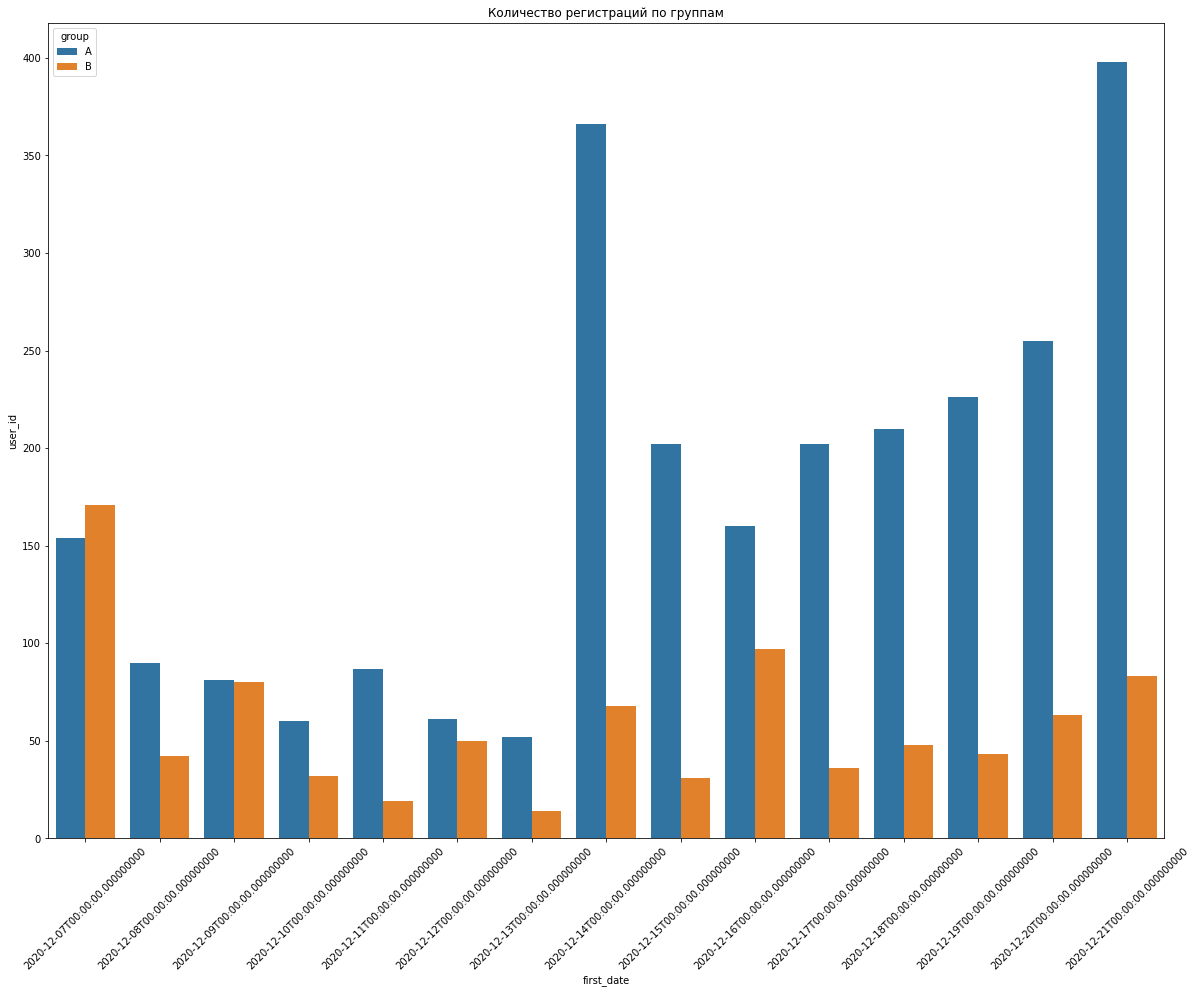

In [79]:
import seaborn as sns
plt.figure(figsize=(20, 15)) 
sns.barplot(x='first_date', y='user_id', hue='group', data=registrations)
plt.title('Количество регистраций по группам')
plt.xticks(rotation = 45)
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
В первый и третий день теста наблюдается примерно равное количество регистраций по группам. А вот в остальное время количество регистраций в группе А сильно превышает количество регистраций в группе В.

### Время проведения теста

<div style="border:solid blue 1px; padding: 20px"> 
Теперь проверим время проведения теста. Как мы уже выяснили, новогодние праздники оказали свое влияние и фактически тест завершился раньше, чем планировалось по ТЗ: 30 декабря вместо 4 января. Теперь проверим календарь маркетинговых событий и посмотрим, не было ли пересечений с ними. Наш тест проходит с 7 по 30 декабря.

In [80]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


<div style="border:solid blue 1px; padding: 20px"> 
С нашим тестом пересекается 1 рекламная кампания: Christmas&New Year Promo, она начинается 25 декабря и длится по 3 января. Следовательно, она могла оказать влияние на рост продаж с 25 декабря. Проверим, так ли это.

In [81]:
all_data_EU['event_date'] = all_data_EU['event_dt'].dt.date
group_date = (all_data_EU[all_data_EU['event_name']=='purchase']
              .pivot_table(index=['group', 'event_date'], values='event_name', aggfunc='count').reset_index())
display(group_date)

,group,event_date,event_name
0,A,2020-12-07,43
1,A,2020-12-08,33
2,A,2020-12-09,47
3,A,2020-12-10,42
4,A,2020-12-11,40
5,A,2020-12-12,38
6,A,2020-12-13,32
7,A,2020-12-14,133
8,A,2020-12-15,137
9,A,2020-12-16,142


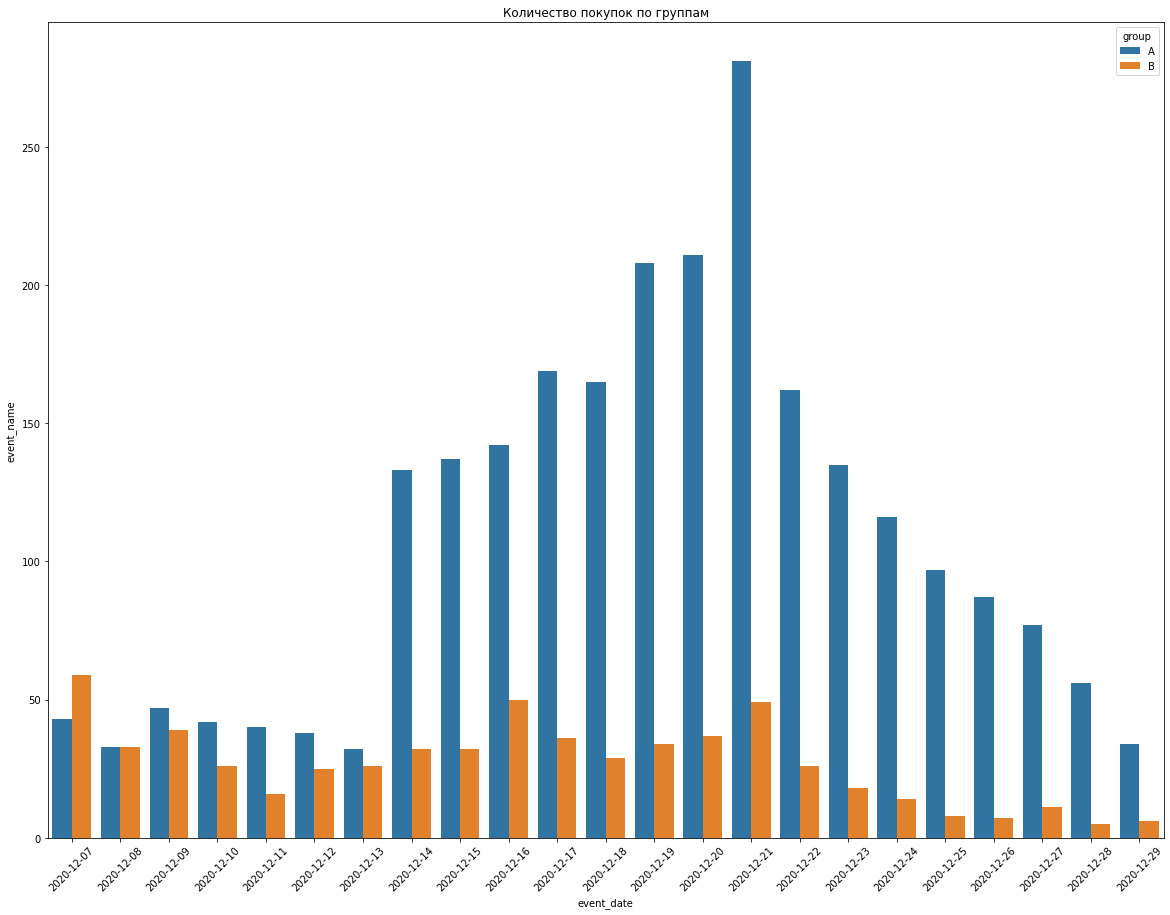

In [82]:
import seaborn as sns
plt.figure(figsize=(20, 15)) 
sns.barplot(x='event_date', y='event_name', hue='group', data=group_date)
plt.title('Количество покупок по группам')
plt.xticks(rotation = 45)
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Как видно на графике выше, количество покупок распределено по группам крайне неравномерно. По группе А наблюдается резкий рост числа покупок спустя неделю с начала теста, и также резкий спад с 22 декабря, когда прекратилась регистрация пользователей. По группе В количество покупок в день уменьшалось с даты начала теста до 11 декабря, далее вплоть до 21 декабря наблюдался рост числа покупок. С 22 декабря, также как и в группе А, количество покупок стало резко уменьшаться. 

Как мы видим, 25 декабря не наблюдается воостановления числа покупок, оно продолжало снижаться до конца наблюдаемого периода. Таким образом можно заключить, что проводимое маркетинговое событие не оказало влияние на проведение теста.

### Вывод

<div style="border:solid blue 1px; padding: 20px"> 
1) Тест не соответствует положениям ТЗ:

- Аудитория теста меньше 15% новых пользователей из региона EU. Таких пользователей 6940, в нашем тесте принимает участие только 6351.
    
- Ожидаемое количество участников теста больше 6000: в тесте участвовало на 701 человека больше (~ +11,7%), или на 351 больше, если считать от европейских пользователей (~ +5,85%).
    
Хотя по факту количество участников оказалось сильно меньше - 3481. Это вызвано тем, что мы не получили данных о действиях на сайте по 2870 пользователям, большинство которых из группы В (1840 участников из группы В и 1030 участников из группы А). Предположительно, произошел какой-то сбой в системе из-за которого часть данных была утеряна. Удалив таких участников, для участия в тесте остался 3481 клиент из 6351.
    
- Дата остановки не 4 января 2021 г., а 30 декабря 2020 г. Возможно, это обусловлено новогодними праздниками, в следствие чего пользователи не совершали действий на сайте;


2) Неравномерное распределение участников теста по группам:
75% участников относятся к группе А, а 25% - к группе В. Такое распределение по группам некорректно.

3) Пересечение с конкурирующим тестом:
В это же время проводилось еще одно тестирование, часть пользователей (431) участвовало и в нашем тесте, и в конкурирующем. Но поскольку доли пользователей группы В из конкурирующего теста равномерно распределены по группам текущего теста, мы заключаем, что его влияние на наш тест распределено равномерно. Поэтому таких пользователей можно не удалять.

4) Временные границы теста:
Тест проводится в неудачное время, накануне новогодних праздников. Возможно, в связи с этим пользователи не совершали никаких действий на сайте с 30 по 4 января.
Также в этот период поведение пользователей отличается, и нельзя на основании полученных результатов делать выводы о поведении клиентов в "обычные" дни.
Более того мы наблюдаем пересечение теста с проведением маркетингового события. Большая часть данных нами была утеряна (о 2870 пользователях), поэтому нельзя с точностью заключить повлияло ли оно на результаты теста. На основании имеющихся данных влияние на количество продаж не наблюдается.

## Исследовательский анализ данных

### Распределение количества событий на пользователя в выборках

<div style="border:solid blue 1px; padding: 20px"> 
Проверим, одинаково ли распределено количество событий на пользователя в выборках

In [83]:
event_qty = all_data_EU.pivot_table(index='user_id', columns='group', values='event_name', aggfunc='count').reset_index()

In [84]:
event_qty.head()

group,user_id,A,B
0,001064FEAAB631A1,NaN,6.0
1,0010A1C096941592,12.0,NaN
2,00341D8401F0F665,2.0,NaN
3,003DF44D7589BBD4,15.0,NaN
4,00505E15A9D81546,5.0,NaN


In [85]:
event_qty_A = event_qty[['user_id', 'A']]
event_qty_A = event_qty_A.dropna()
event_qty_B = event_qty[['user_id', 'B']]
event_qty_B = event_qty_B.dropna()

In [86]:
display(event_qty_A['A'].mean())
display(event_qty_B['B'].mean())

6.849078341013825

5.456100342075256

<div style="border:solid blue 1px; padding: 20px"> 
В среднем пользователь из группы А совершает 7 событий, а из группы В - 5 событий.

<div style="border:solid blue 1px; padding: 20px"> 
Проверим также статистическую гипотезу, что в группах в среднем количество событий на пользователя одинаково. За нулевую гипотезу возьмем то, что в среднем количество событий на пользователя в группе А равно количеству событий на пользователя в группе В, альтернативная гипотеза - количество событий на пользователя различается.

<div style="border:solid blue 1px; padding: 20px"> 
Проверим, распределены ли наши данные нормально. Критический уровень статистической значимости примем равным 0.05.

In [87]:
alpha = 0.05

results = st.shapiro(event_qty_A['A'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
     print('Не получилось отвергнуть нулевую гипотезу, всё нормально')
        
results = st.shapiro(event_qty_B['B'])
p_value = results[1]

print('p-значение: ', p_value)

if p_value < alpha:
    print('Отвергаем нулевую гипотезу: распределение не нормально')
else:
     print('Не получилось отвергнуть нулевую гипотезу, всё нормально')        

p-значение:  4.153490763443324e-35
Отвергаем нулевую гипотезу: распределение не нормально
p-значение:  3.3629680266253744e-25
Отвергаем нулевую гипотезу: распределение не нормально


<div style="border:solid blue 1px; padding: 20px">
Распределение не нормально. В таком случае для проверки нашей гипотезы применим непараметрический тест Уилкоксона-Манна-Уитни. Критический уровень статистической значимости примем равным 0.05.

In [88]:
alpha = 0.05

sample_0 = event_qty_A['A']
sample_1 = event_qty_B['B']

results = st.mannwhitneyu(sample_0, sample_1)

if results.pvalue < alpha:
      print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
     print(
        'Не получилось отвергнуть нулевую гипотезу, вывод о различии сделать нельзя')

Отвергаем нулевую гипотезу: разница статистически значима


<div style="border:solid blue 1px; padding: 20px"> 
Отвергаем нулевую гипотезу о равенстве средних. Количество событий на пользователя в группе А не равно количеству событий на пользователя в группе В.

### Распределение количества событий по дням в выборках

Проверим, как число событий в выборках распределено по дням

In [89]:
group_date_2 = all_data_EU.pivot_table(index=['group', 'event_date'], values='event_name', aggfunc='count').reset_index()
display(group_date_2)

,group,event_date,event_name
0,A,2020-12-07,318
1,A,2020-12-08,313
2,A,2020-12-09,371
3,A,2020-12-10,331
4,A,2020-12-11,356
5,A,2020-12-12,346
6,A,2020-12-13,308
7,A,2020-12-14,1015
8,A,2020-12-15,1030
9,A,2020-12-16,1007


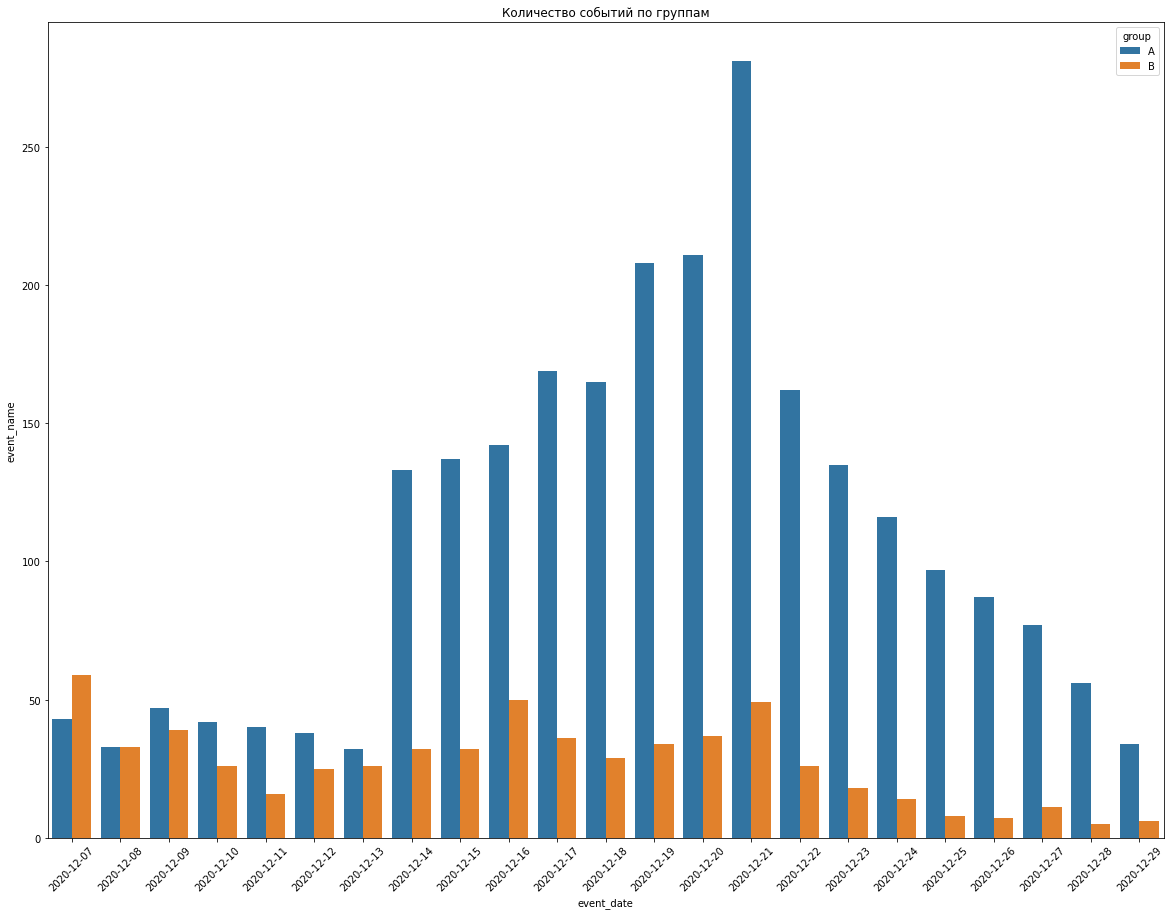

In [90]:
import seaborn as sns
plt.figure(figsize=(20, 15)) 
sns.barplot(x='event_date', y='event_name', hue='group', data=group_date)
plt.title('Количество событий по группам')
plt.xticks(rotation = 45)
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Здесь так же картина аналогична ситуации с количеством покупок по дням. Максимальное число событий наблюдается в период с 14 по 21 декабря. 
Также интересно отметить, что количество событий по группе В лишь в первый день, 7 декабря, превысило количество событий в группе А.

### Воронка событий

<div style="border:solid blue 1px; padding: 20px"> 
Далее проверим, как меняется конверсия в воронке в выборках на разных этапах

In [91]:
all_data_EU_A = all_data_EU[all_data_EU['group']=='A']
all_data_EU_B = all_data_EU[all_data_EU['group']=='B']

In [92]:
event_pt_A = (all_data_EU_A.groupby('event_name').agg({'user_id':'nunique'})
            .sort_values('user_id', ascending=False).reset_index())
event_pt_A.columns = ['event_name', 'user_id_qty']
event_pt_A['percent'] = round(event_pt_A['user_id_qty']/event_pt_A.iloc[0]['user_id_qty']*100,2)
display(event_pt_A)

,event_name,user_id_qty,percent
0,login,2604,100.00
1,product_page,1685,64.71
2,purchase,833,31.99
3,product_cart,782,30.03


In [93]:
event_pt_B = (all_data_EU_B.groupby('event_name').agg({'user_id':'nunique'})
            .sort_values('user_id', ascending=False).reset_index())
event_pt_B.columns = ['event_name', 'user_id_qty']
event_pt_B['percent'] = round(event_pt_B['user_id_qty']/event_pt_B.iloc[0]['user_id_qty']*100,2)
display(event_pt_B)

,event_name,user_id_qty,percent
0,login,876,100.00
1,product_page,493,56.28
2,purchase,249,28.42
3,product_cart,244,27.85


<div style="border:solid blue 1px; padding: 20px"> 
Всего в имеющихся данных 4 события: вход в систему, посещение страниц товара, корзины, покупка. Чаще всего пользователи входят в систему, далее попадают на страницу товара. Интересно отметить, что количество покупок больше, чем количеств посещение корзины. Значит, купить товар возможно минуя корзину.
Построим воронку в правильном порядке: вход в систему, посещение страниц товара, корзины, покупка.

In [94]:
def step(row):
    event=row['event_name']
    
    if event == 'login':
        return 1
    if event == 'product_page':
        return 2
    if event == 'product_cart':
        return 3
    if event == 'purchase':
        return 4    

In [95]:
event_pt_A['step'] = event_pt_A.apply(step, axis=1)
event_pt_B['step'] = event_pt_B.apply(step, axis=1)

In [96]:
event_pt_A

,event_name,user_id_qty,percent,step
0,login,2604,100.00,1
1,product_page,1685,64.71,2
2,purchase,833,31.99,4
3,product_cart,782,30.03,3


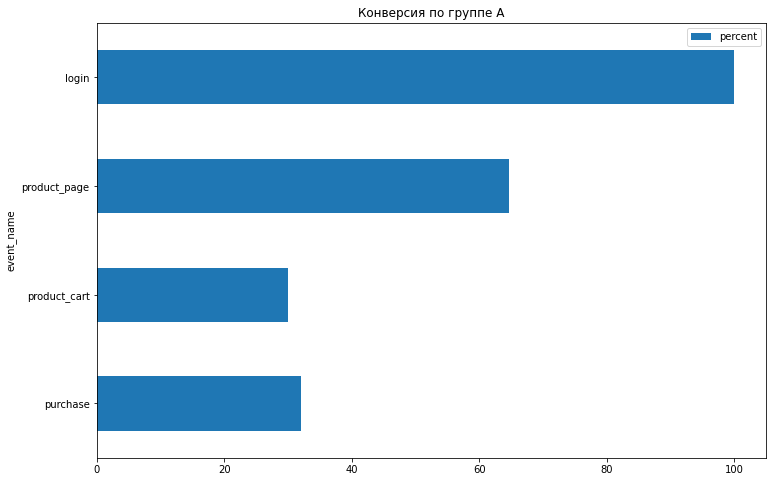

In [97]:
event_pt_A.sort_values(by='step', ascending=False).plot(x='event_name', y='percent', kind='barh', figsize=(12,8))
plt.title('Конверсия по группе А')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Исходя из таблицы выше конверсия по группе А следующая:

- 64,71% зарегистрировавшихся переходят на страницу товара;
- 30,33% зарегистрировавшихся переходят в корзину;
- 31,99% зарегистрировавшихся покупают товар;

In [98]:
event_pt_B

,event_name,user_id_qty,percent,step
0,login,876,100.00,1
1,product_page,493,56.28,2
2,purchase,249,28.42,4
3,product_cart,244,27.85,3


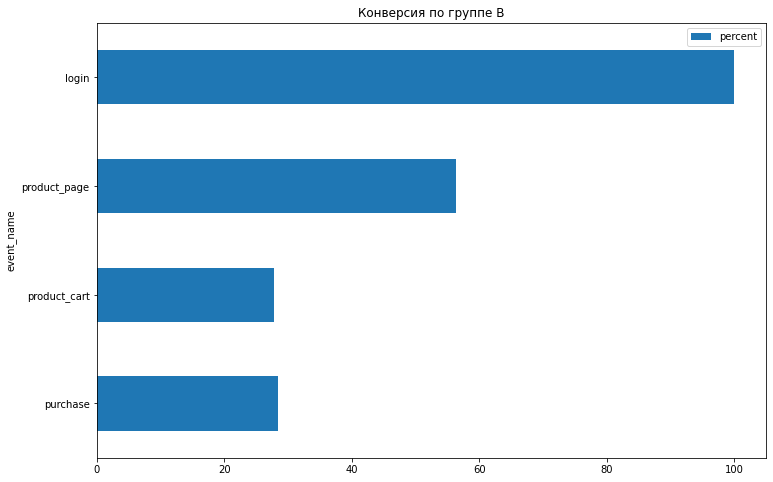

In [99]:
event_pt_B.sort_values(by='step', ascending=False).plot(x='event_name', y='percent', kind='barh', figsize=(12,8))
plt.title('Конверсия по группе B')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Исходя из таблицы выше конверсия по группе В следующая:

- 56,28% зарегистрировавшихся переходят на страницу товара;
- 27,85% зарегистрировавшихся переходят в корзину;
- 28,42% зарегистрировавшихся покупают товар;

<div style="border:solid blue 1px; padding: 20px"> 
Конверсия по группе А выше, чем по группе В по всем событиям

### Вывод

<div style="border:solid blue 1px; padding: 20px"> 
1) Количество событий в среднем на пользователя в выборках отличается: количество событий в группе А, больше чем в группе В;

2) Количество событий по дням неравномерно: максимальное число событий наблюдается в период с 14 по 21 декабря. Отметим, что количество событий по группе В лишь в первый день, 7 декабря, превысило количество событий в группе А.

3) Воронка событий;
Всего в имеющихся данных 4 события: авторизация, посещение страниц товара, корзины, покупка. Интересно отметить, что количество покупок больше, чем количество посещений корзины. Значит, купить товар возможно минуя корзину.
Конверсия на каждом этапе в группе А выше, чем в группе В.

## Оценка результатов A/B-тестирования

### Проверка гипотез о равенстве долей

<div style="border:solid blue 1px; padding: 20px"> 
Проверим гипотезы о равенстве долей пользователей, перешедших на каждый этап воронки

In [102]:
pivot_total = all_data_EU[all_data_EU['event_name']=='login'].pivot_table(index='group', values='user_id', aggfunc='nunique')
pivot_total

,user_id
group,
A,2604
B,876


In [103]:
pivot = all_data_EU[all_data_EU['event_name']!='login'].pivot_table(index='group', values='user_id', columns='event_name', aggfunc='nunique')
pivot

event_name,product_cart,product_page,purchase
group,,,
A,782,1685,833
B,244,493,249


<div style="border:solid blue 1px; padding: 20px"> 
Сравним пропорции выборок, по доле пользователей, перешедших на каждый этап воронки (страница товара, страница корзины, оформление заказа). За нулевую гипотезу примем равенство пропорций переходов в обеих группах, за альтернативную - что пропорции различаются. Уровень значимости зададим равным 5%. Так как проводится множественная проверка, используем поправку Бонферрони.

In [106]:
def z_test(group1, group2, event):
    
    alpha = .05
    bonferroni_alpha = alpha / 3 #количество сравнений равно 3
        
    # пропорция успехов в первой группе:
    p1 = pivot.loc[group1][event]/pivot_total.loc[group1]['user_id']

    # пропорция успехов во второй группе:
    p2 = pivot.loc[group2][event]/pivot_total.loc[group2]['user_id']

    # пропорция успехов в комбинированном датасете:
    p_combined = (pivot.loc[group1][event] + pivot.loc[group2][event]) / (pivot_total.loc[group1]['user_id'] + pivot_total.loc[group2]['user_id'])

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/pivot_total.loc[group1]['user_id'] + 1/pivot_total.loc[group2]['user_id']))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('Проверка гипотезы о равенстве долей пользователей, перешедших на этап {}'.format(event))
    
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу')
    else:
        print('Не получилось отвергнуть нулевую гипотезу')

In [107]:
for event in pivot.columns:
    z_test('A', 'B', event)
    print()

Проверка гипотезы о равенстве долей пользователей, перешедших на этап product_cart
Не получилось отвергнуть нулевую гипотезу

Проверка гипотезы о равенстве долей пользователей, перешедших на этап product_page
Отвергаем нулевую гипотезу

Проверка гипотезы о равенстве долей пользователей, перешедших на этап purchase
Не получилось отвергнуть нулевую гипотезу



<div style="border:solid blue 1px; padding: 20px"> 
Таким образом доли конверсии на этапе перехода на страницу товара разные, а перехода на страницу корзины и оформления заказа в обеих группах равны

### Стабильность кумулятивных метрик

In [108]:
all_data_EU.head()

,user_id,group,ab_test,event_dt,event_name,details,first_date,region,device,diff,event_date
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,purchase,99.99,2020-12-07,EU,PC,0 days 14:43:27,2020-12-07
2,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:29,product_cart,0.00,2020-12-07,EU,PC,0 days 14:43:29,2020-12-07
4,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,product_page,0.00,2020-12-07,EU,PC,0 days 14:43:27,2020-12-07
6,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07 14:43:27,login,0.00,2020-12-07,EU,PC,0 days 14:43:27,2020-12-07
8,A7A3664BD6242119,A,recommender_system_test,2020-12-20 15:46:06,product_page,0.00,2020-12-20,EU,iPhone,0 days 15:46:06,2020-12-20


<div style="border:solid blue 1px; padding: 20px"> 
Далее изучим графики накапливаемых данных, построим графики кумулятивной конверсии по дням по группам

<div style="border:solid blue 1px; padding: 20px"> 
Соберем и агрегируем данные по каждому этапу

In [109]:
data_login = all_data_EU[all_data_EU['event_name']=='login']
data_product_page = all_data_EU[all_data_EU['event_name']=='product_page']
data_product_cart = all_data_EU[all_data_EU['event_name']=='product_cart']
data_purchase = all_data_EU[all_data_EU['event_name']=='purchase']

In [110]:
datesGroups = data_purchase[['event_date','group']].drop_duplicates() #для подсчета количества заказов

In [111]:
datesGroups_2 = all_data_EU[['event_date','group']].drop_duplicates() #для подсчета количества посетителей

In [112]:
datesGroups_3 = data_login[['event_date','group']].drop_duplicates() #для подсчета количества авторизаций

In [113]:
datesGroups_4 = data_product_page[['event_date','group']].drop_duplicates() #для подсчета количества посещений страниц товара

In [114]:
datesGroups_5 = data_product_cart[['event_date','group']].drop_duplicates() #для подсчета количества посещений корзины

In [115]:
visitorsAggregated = (datesGroups_2.apply(lambda x: all_data_EU[
    np.logical_and(all_data_EU['event_date'] <= x['event_date'], all_data_EU['group'] == x['group'])]
    .agg({'event_date' : 'max', 'group' : 'max', 'user_id' : 'nunique'}), axis=1)
    .sort_values(by=['event_date','group'])) #объединенные данные о количестве посетителей

In [116]:
purchasesAggregated = (datesGroups.apply(lambda x: data_purchase[
    np.logical_and(data_purchase['event_date'] <= x['event_date'], data_purchase['group'] == x['group'])]
    .agg({'event_date' : 'max', 'group' : 'max', 'user_id' : 'nunique', 'details':'sum'}), axis=1)
    .sort_values(by=['event_date','group'])) #объединенные данные о количестве заказов

In [117]:
loginsAggregated = (datesGroups_3.apply(lambda x: data_login[
    np.logical_and(data_login['event_date'] <= x['event_date'], data_login['group'] == x['group'])]
    .agg({'event_date' : 'max', 'group' : 'max', 'user_id' : 'nunique'}), axis=1)
    .sort_values(by=['event_date','group'])) #объединенные данные о количестве логов

In [118]:
product_pageAggregated = (datesGroups_4.apply(lambda x: data_product_page[
    np.logical_and(data_product_page['event_date'] <= x['event_date'], data_product_page['group'] == x['group'])]
    .agg({'event_date' : 'max', 'group' : 'max', 'user_id' : 'nunique'}), axis=1)
    .sort_values(by=['event_date','group'])) #объединенные данные о количестве посещений страниц товаров

In [119]:
product_cartAggregated = (datesGroups_5.apply(lambda x: data_product_cart[
    np.logical_and(data_product_cart['event_date'] <= x['event_date'], data_product_cart['group'] == x['group'])]
    .agg({'event_date' : 'max', 'group' : 'max', 'user_id' : 'nunique'}), axis=1)
    .sort_values(by=['event_date','group'])) #объединенные данные о количестве посещений корзины

In [120]:
purchasesAggregated.head()

,event_date,group,user_id,details
0,2020-12-07,A,43,1104.57
105,2020-12-07,B,59,704.41
5381,2020-12-08,A,65,1859.24
195,2020-12-08,B,69,1189.08
60,2020-12-09,A,88,2618.77


In [121]:
cumulativeData = (purchasesAggregated.merge(visitorsAggregated, left_on=['event_date', 'group']
                                         , right_on=['event_date', 'group']))
cumulativeData.columns = ['event_date','group', 'purchases_qty', 'revenue_sum', 'visitors_qty'] #объединенные данные о количестве заказов и регистраций

In [122]:
cumulativeData.head()

,event_date,group,purchases_qty,revenue_sum,visitors_qty
0,2020-12-07,A,43,1104.57,148
1,2020-12-07,B,59,704.41,163
2,2020-12-08,A,65,1859.24,240
3,2020-12-08,B,69,1189.08,207
4,2020-12-09,A,88,2618.77,322


In [123]:
cumulativeData2 = (loginsAggregated.merge(visitorsAggregated, left_on=['event_date', 'group']
                                         , right_on=['event_date', 'group']))
cumulativeData2.columns = ['event_date','group', 'logins_qty', 'visitors_qty'] #объединенные данные о количестве логов и регистраций

In [124]:
cumulativeData3 = (product_pageAggregated.merge(visitorsAggregated, left_on=['event_date', 'group']
                                         , right_on=['event_date', 'group']))
cumulativeData3.columns = ['event_date','group', 'product_page_qty', 'visitors_qty'] #объединенные данные о количестве посещений страниц товаров и регистраций

In [125]:
cumulativeData4 = (product_cartAggregated.merge(visitorsAggregated, left_on=['event_date', 'group']
                                         , right_on=['event_date', 'group']))
cumulativeData4.columns = ['event_date','group', 'product_cart_qty', 'visitors_qty'] #объединенные данные о количестве посещений корзины и регистраций

<div style="border:solid blue 1px; padding: 20px"> 
Посчитаем конверсию каждого этапа: сколько посетителей авторизировались/перешли на страницу товара/корзины, оформили покупку

In [126]:
cumulativeData['conversion'] = cumulativeData['purchases_qty'] / cumulativeData['visitors_qty']
cumulativeData2['conversion'] = cumulativeData2['logins_qty'] / cumulativeData2['visitors_qty']
cumulativeData3['conversion'] = cumulativeData3['product_page_qty'] / cumulativeData3['visitors_qty']
cumulativeData4['conversion'] = cumulativeData4['product_cart_qty'] / cumulativeData4['visitors_qty']

<div style="border:solid blue 1px; padding: 20px"> 
Построим графики кумулятивной конверсии по каждому этапу

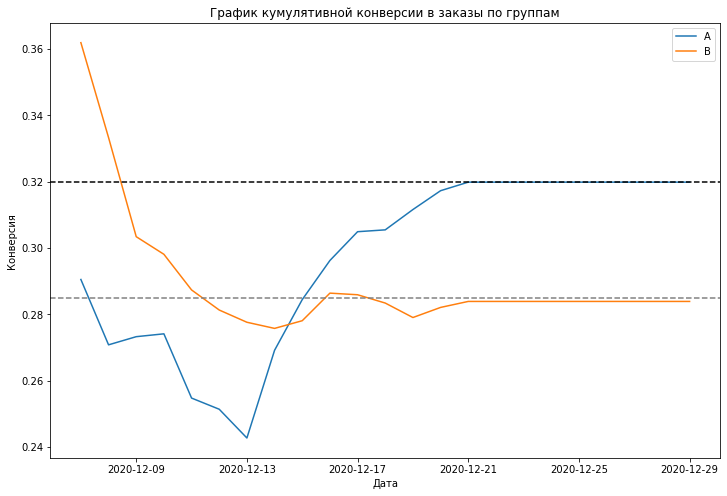

In [127]:
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(12, 8))
plt.plot(cumulativeDataA['event_date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['event_date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии в заказы по группам')
plt.axhline(y=0.32, color='black', linestyle='--')
plt.axhline(y=0.285, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
В начале теста конверсия в заказы была выше у группы B. До 13 декабря конверсия в обеих группах снизилась примерно на 5%. Далее по группе B она выравнялась и оставалась неизменной до конца теста (28,5%). А по группе A конверсия за неделю выросла на 8%  с 13 по 21 декабря. Далее она также осталась неизменной до конца теста (32%). Стабильность показателя после 21 декабря можно объяснить прекращением регистрации новых пользователей.

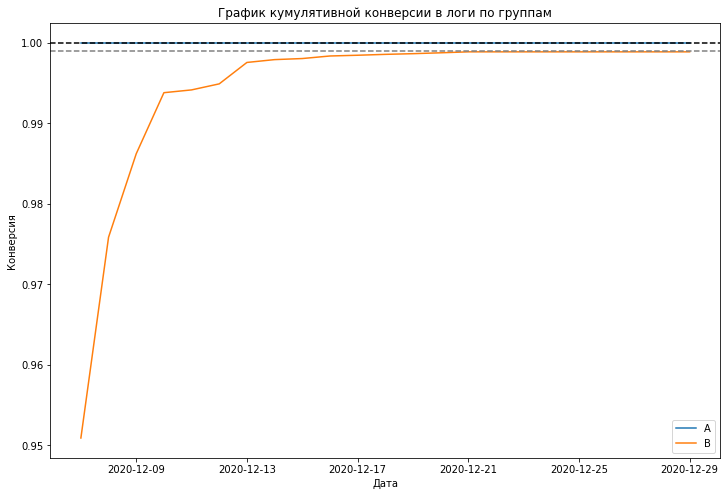

In [128]:
cumulativeData2A = cumulativeData2[cumulativeData2['group']=='A']
cumulativeData2B = cumulativeData2[cumulativeData2['group']=='B']

plt.figure(figsize=(12, 8))
plt.plot(cumulativeData2A['event_date'], cumulativeData2A['conversion'], label='A')
plt.plot(cumulativeData2B['event_date'], cumulativeData2B['conversion'], label='B')
plt.legend()
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии в логи по группам')
plt.axhline(y=1, color='black', linestyle='--')
plt.axhline(y=0.999, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Конверсия в авторизацию группы А стабильно равна 100%, тогда как по группе В в начале теста составляла 95%, а с 13 декабря почти достигла отметки в 100%

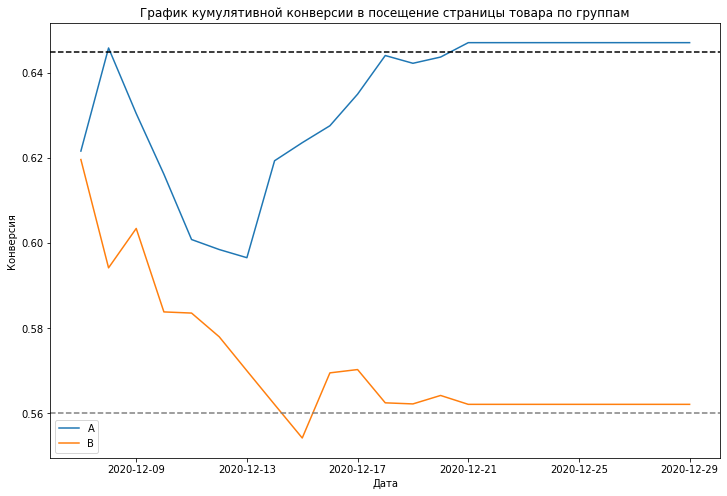

In [129]:
cumulativeData3A = cumulativeData3[cumulativeData3['group']=='A']
cumulativeData3B = cumulativeData3[cumulativeData3['group']=='B']

plt.figure(figsize=(12, 8))
plt.plot(cumulativeData3A['event_date'], cumulativeData3A['conversion'], label='A')
plt.plot(cumulativeData3B['event_date'], cumulativeData3B['conversion'], label='B')
plt.legend()
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии в посещение страницы товара по группам')
plt.axhline(y=0.645, color='black', linestyle='--')
plt.axhline(y=0.56, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
В начале теста группы А и В однинаково активно открывали страницы товаров. Далее конверсия группы А выросла 9 декабря на 2%, а далее снижалась до 60% вплоть до 13 декабря. Со следующего дня уже наблюдался рост посещений страниц товара, 21 декабря он достиг 64,5% и зафиксировался на этом уровне до конца теста.
По группе В конверсия снижалась вплоть до 15 декабря, достигнув отметки в 55,5%. С 21 декабря конверсия зафиксировалась на отметке в 56,5%.

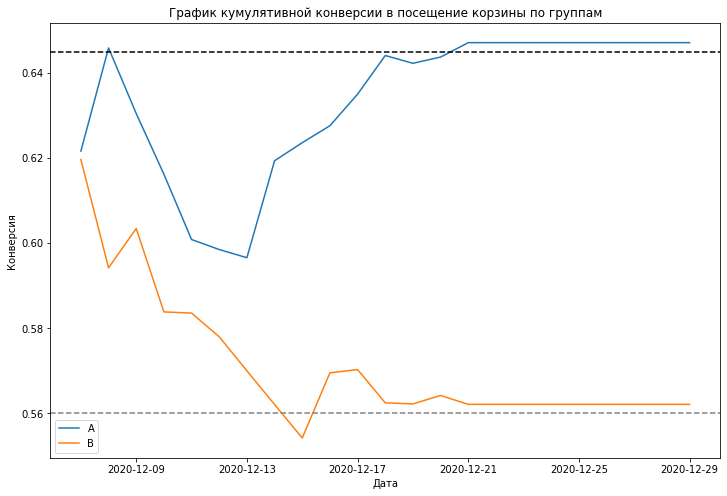

In [130]:
cumulativeData4A = cumulativeData3[cumulativeData4['group']=='A']
cumulativeData4B = cumulativeData3[cumulativeData4['group']=='B']

plt.figure(figsize=(12, 8))
plt.plot(cumulativeData4A['event_date'], cumulativeData4A['conversion'], label='A')
plt.plot(cumulativeData4B['event_date'], cumulativeData4B['conversion'], label='B')
plt.legend()
plt.ylabel('Конверсия')
plt.xlabel('Дата')
plt.title('График кумулятивной конверсии в посещение корзины по группам')
plt.axhline(y=0.645, color='black', linestyle='--')
plt.axhline(y=0.56, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Динамика конверсии в посещение корзины похожа на конверсию в посещение страницы товара. На конец периода по группе А она зафиксировалась на 64,5%, по группе В - 56,5%.

<div style="border:solid blue 1px; padding: 20px"> 
Далее построим графики относительного изменения кумулятивной конверсии группы B к группе A

No handles with labels found to put in legend.


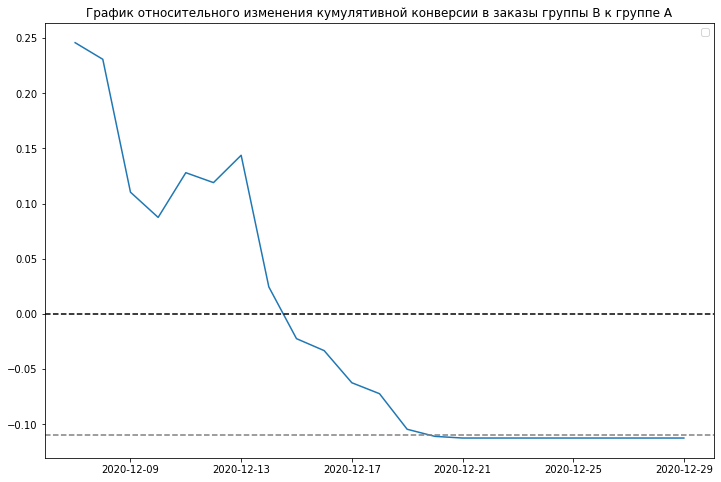

In [131]:
cumulative_conversion_merged_purchases = (cumulativeDataA[['event_date', 'conversion']]
                                .merge(cumulativeDataB[['event_date', 'conversion']]
                                       , left_on='event_date', right_on='event_date', suffixes=['A', 'B']))

plt.figure(figsize=(12, 8))
plt.plot(cumulative_conversion_merged_purchases['event_date'], cumulative_conversion_merged_purchases['conversionB']/
         cumulative_conversion_merged_purchases['conversionA'] - 1)
plt.legend()
plt.rcParams["figure.figsize"] = (12,8)
plt.title('График относительного изменения кумулятивной конверсии в заказы группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.11, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Конверсия в заказы группы В с момента начала теста снизилась на 35 %. К окончанию теста конверсия группы A превышала конверсию группы В на 10%.

No handles with labels found to put in legend.


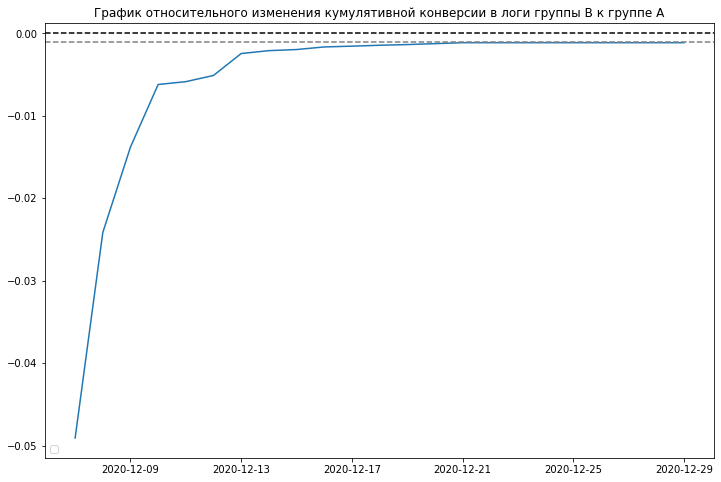

In [132]:
cumulative_conversion_merged_logins = (cumulativeData2A[['event_date', 'conversion']]
                                .merge(cumulativeData2B[['event_date', 'conversion']]
                                       , left_on='event_date', right_on='event_date', suffixes=['A', 'B']))

plt.figure(figsize=(12, 8))
plt.plot(cumulative_conversion_merged_logins['event_date'], cumulative_conversion_merged_logins['conversionB']/
         cumulative_conversion_merged_logins['conversionA'] - 1)
plt.legend()
plt.rcParams["figure.figsize"] = (12,8)
plt.title('График относительного изменения кумулятивной конверсии в логи группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.001, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Конверсия в логи группы В с момента начала теста повысилась на 5 %. К окончанию теста конверсия группы A превышала конверсию группы В на 0,1%.

No handles with labels found to put in legend.


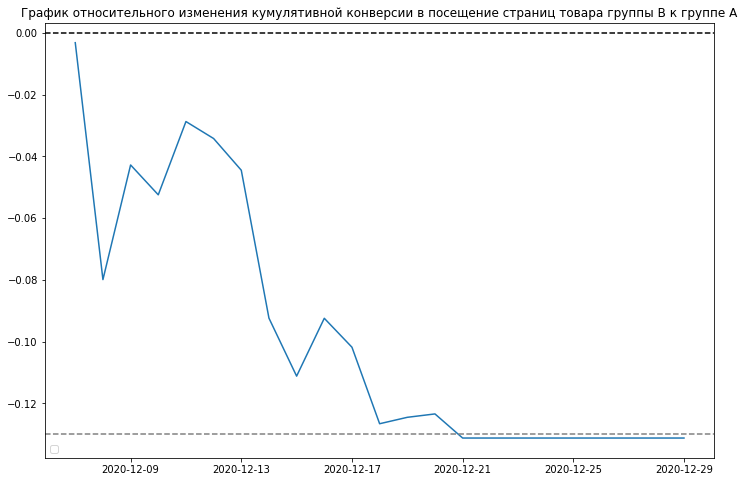

In [133]:
cumulative_conversion_merged_product_page = (cumulativeData3A[['event_date', 'conversion']]
                                .merge(cumulativeData3B[['event_date', 'conversion']]
                                       , left_on='event_date', right_on='event_date', suffixes=['A', 'B']))

plt.figure(figsize=(12, 8))
plt.plot(cumulative_conversion_merged_product_page['event_date'], cumulative_conversion_merged_product_page['conversionB']/
         cumulative_conversion_merged_product_page['conversionA'] - 1)
plt.legend()
plt.rcParams["figure.figsize"] = (12,8)
plt.title('График относительного изменения кумулятивной конверсии в посещение страниц товара группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.13, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Конверсия в посещение страниц товара группы В с момента начала теста снизилась на 13 %. К окончанию теста конверсия группы A превышала конверсию группы В на 13%.

No handles with labels found to put in legend.


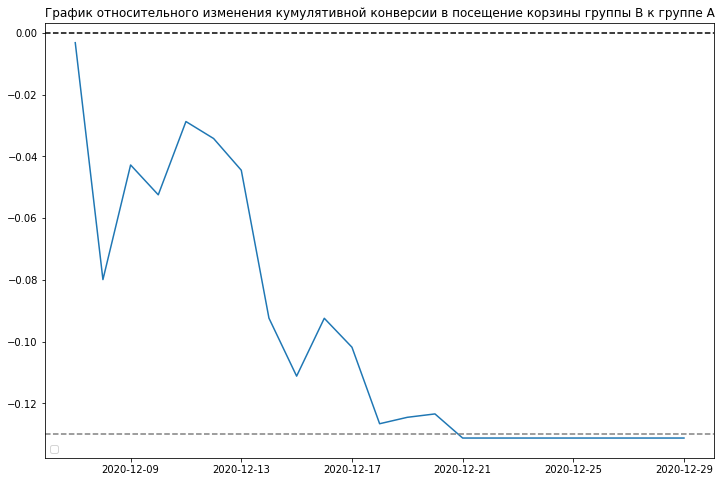

In [134]:
cumulative_conversion_merged_product_cart = (cumulativeData4A[['event_date', 'conversion']]
                                .merge(cumulativeData4B[['event_date', 'conversion']]
                                       , left_on='event_date', right_on='event_date', suffixes=['A', 'B']))

plt.figure(figsize=(12, 8))
plt.plot(cumulative_conversion_merged_product_cart['event_date'], cumulative_conversion_merged_product_cart['conversionB']/
         cumulative_conversion_merged_product_cart['conversionA'] - 1)
plt.legend()
plt.rcParams["figure.figsize"] = (12,8)
plt.title('График относительного изменения кумулятивной конверсии в посещение корзины группы B к группе A')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.13, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
Конверсия в посещение корзины группы В с момента начала теста снизилась на 13 %. К окончанию теста конверсия группы A превышала конверсию группы В на 13%.

<div style="border:solid blue 1px; padding: 20px"> 
Далее построим графики кумулятивной выручки по группам и кумулятивного среднего чека по группам

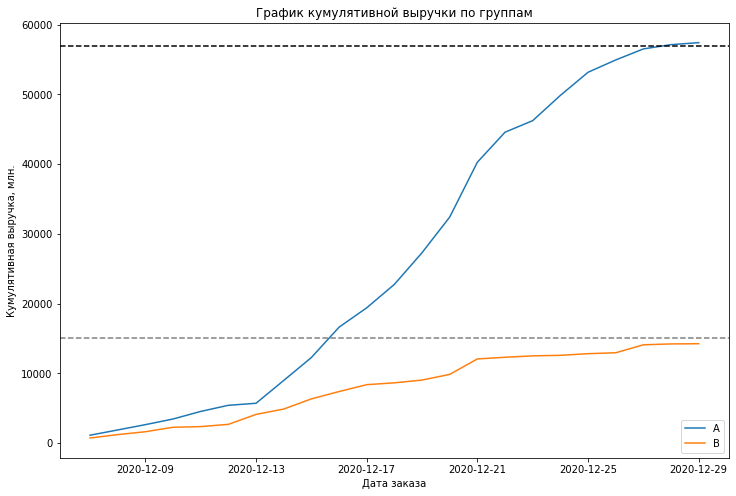

In [135]:
cumulative_revenue_a = cumulativeData[cumulativeData['group'] == 'A']
[['event_date', 'purchases_qty', 'revenue_sum']]
cumulative_revenue_b = cumulativeData[cumulativeData['group'] == 'B']
[['event_date', 'purchases_qty', 'revenue_sum']]

plt.rcParams["figure.figsize"] = (12,8)
plt.plot(cumulative_revenue_a['event_date'], cumulative_revenue_a['revenue_sum'], label='A')
plt.plot(cumulative_revenue_b['event_date'], cumulative_revenue_b['revenue_sum'], label='B')
plt.legend()
plt.ylabel('Кумулятивная выручка, млн.')
plt.xlabel('Дата заказа')
plt.title('График кумулятивной выручки по группам')
plt.axhline(y=57000, color='black', linestyle='--')
plt.axhline(y=15000, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
До 13 декабря выручка по группам была примерно одинаковой. Далее по группе А выручка начало резко расти и к 29 декабря увеличилась до 57000 у.е. По группе В на конец периода выручка составила 15000 у.е.

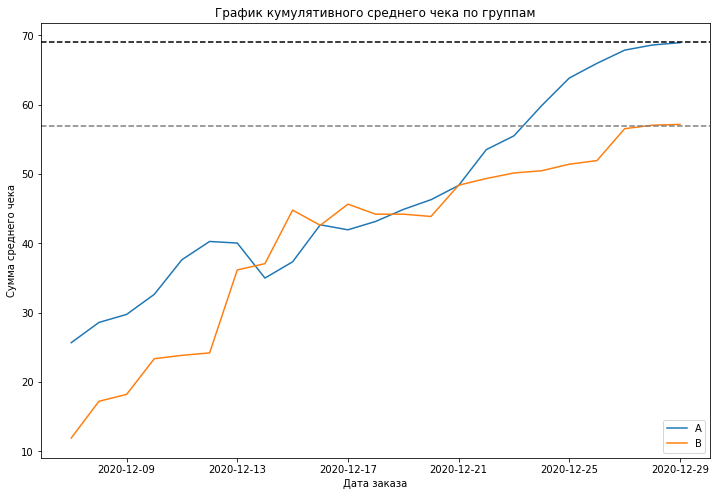

In [136]:
plt.plot(cumulative_revenue_a['event_date'], cumulative_revenue_a['revenue_sum']/
         cumulative_revenue_a['purchases_qty'], label='A')
plt.plot(cumulative_revenue_b['event_date'], cumulative_revenue_b['revenue_sum']/
         cumulative_revenue_b['purchases_qty'], label='B')
plt.legend()
plt.rcParams["figure.figsize"] = (12,8)
plt.ylabel('Сумма среднего чека')
plt.xlabel('Дата заказа')
plt.title('График кумулятивного среднего чека по группам')
plt.axhline(y=69, color='black', linestyle='--')
plt.axhline(y=57, color='grey', linestyle='--')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
С 14 по 21 декабря средний чек по группам был прмерно одинаковым и колебался в пределах 35-45 у.е. К концу периода сумма среднего чека по группе А составила 69 у.е., по группе В - 57 у.е.

In [137]:
cumulative_revenue_merged = cumulative_revenue_a.merge(cumulative_revenue_b, left_on='event_date', 
                                                        right_on='event_date', suffixes=['A', 'B'])

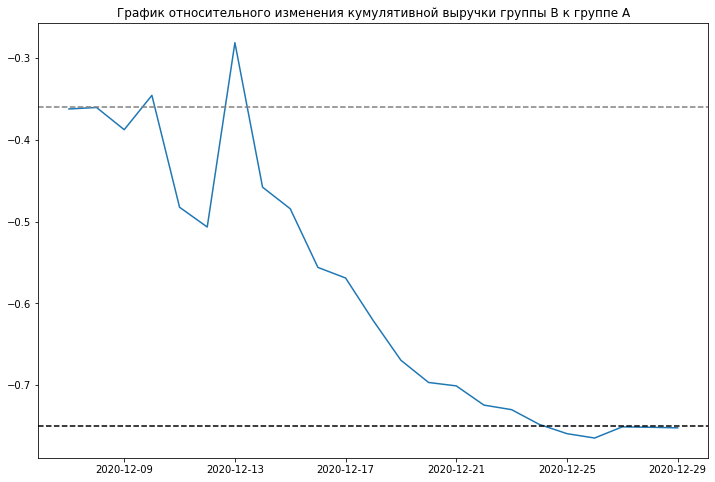

In [138]:
plt.plot(cumulative_revenue_merged['event_date'],
         cumulative_revenue_merged['revenue_sumB']/
        cumulative_revenue_merged['revenue_sumA']-1)
plt.axhline(y=-0.75, color='black', linestyle='--')
plt.axhline(y=-0.36, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивной выручки группы B к группе A')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
В начале рассматриваемого периода выручка по группе А превышала выручку по группе В на 36%, к концу периода превышение составило уже 75%.

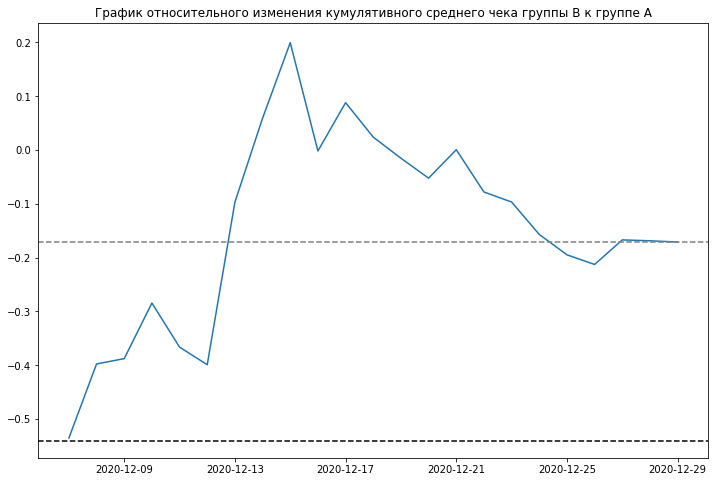

In [139]:
plt.plot(cumulative_revenue_merged['event_date'],
         (cumulative_revenue_merged['revenue_sumB']/cumulative_revenue_merged['purchases_qtyB'])/
        (cumulative_revenue_merged['revenue_sumA']/cumulative_revenue_merged['purchases_qtyA'])-1)
plt.axhline(y=-0.54, color='black', linestyle='--')
plt.axhline(y=-0.17, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.show()

<div style="border:solid blue 1px; padding: 20px"> 
В начале рассматриваемого периода средний чек по группе А превысил средний чек по группе В на 54%, к концу периода разница стала выравниваться и превышение составило уже 17%.

### Вывод

<div style="border:solid blue 1px; padding: 20px"> 

1) По итогам проверки гипотез о равенстве долей, мы наблюдаем что доля пользователей перешедших на страницу просмотра корзины и оформивших покупку одинакова для обеих групп, а вот доля перешедших на страницу просмотра товара - нет.  
    
2) По построенным графикам куммулятивных метрик также видно, что группа В уступает группе А как по конверсии на всех этапах, так и по выручке и среднему чеку.
    
3) Условие последнего пункта ТЗ "за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%" не соблаюдается ни для группы А, ни для группы В.

## Выводы

<div style="border:solid blue 1px; padding: 20px"> 
    По итогам проверки A/B-тестирования можно сделать следующие выводы:
    
1) Тест не соответствует положениям ТЗ;

2) Участники теста неравномерно распределены по группам;

3) Пересечение с конкурирующим тестом;

4) Некорректные временные границы теста;

5) Количество событий в среднем на пользователя в выборках отличается;

6) Количество событий по дням распределено неравномерно;

7) Всего в имеющихся данных 4 события: авторизация, посещение страниц товара, корзины, покупка. Конверсия на каждом этапе в группе А выше, чем в группе В.
    
8) По итогам проверки гипотез о равенстве долей, мы наблюдаем что доля авторизировавшихся пользователей и пользователей перешедших на страницу просмотра корзины одинакова для обеих групп, а вот доля перешедших на страницу просмотра товара и оформивших покупку - нет. Здесь группа А лидирует по сравнению с группой В.
 
9) По построенным графикам куммулятивных метрик также видно, что группа В уступает группе А как по конверсии на всех этапах, так и по выручке и среднему чеку.

<div style="border:solid blue 1px; padding: 20px"> 
Таким образом нельзя сделать вывод о корректности проведенного теста, в ходе его проведения было выявлено много нарушений и несоответствий. Рекомендуется провести тест заново, с учетом описанных выше ошибок.